In [1]:
import nidaqmx 
import numpy as np
import matplotlib.pyplot as plt
import visa
import time
from lantz import MessageBasedDriver, Q_
from lantz.core import Feat
from lantz.core import mfeats
from lantz import ureg

In [2]:
def adquisicion(task,time,freq):
    dt = np.divide(1,freq)
   # print(dt)
    time_vector = np.arange(0,time,dt)
   # print(len(time_vector))
    num_of_points = len(time_vector)  
    data = task.read(number_of_samples_per_channel=num_of_points)
   # print(len(data))
    return (time_vector,np.asarray(data))

In [3]:
class Generador(MessageBasedDriver):

    set_query = MessageBasedDriver.write

    @Feat()
    def idn(self):
        return self.query('*IDN?')
    
    frequency = mfeats.QuantityFeat('SOURce1:FREQuency:FIXed?','SOURce1:FREQuency:FIXed {}',units='Hz',limits=(0.0,1000000))
    amplitude = mfeats.QuantityFeat('SOURce1:VOLT:LEV:IMM:AMPL?','SOURce1:VOLT:LEV:IMM:AMPL {}',units='V',limits=(0.05,5))
        
    def setWaveform(self,waveform ='Senoidal'):
        switcher = {'Senoidal':"SIN",'Cuadrada':"SQU",'Pulso':"PULS"}
        self.write("SOURce1:FUNCtion "+switcher.get(waveform,'Senoidal'))  

In [4]:
def sweepe(gener,init_freq = 100, end_freq = 10100, cant_med = 100):
    with gener as generador:
        paso = np.floor(np.divide(end_freq - init_freq,cant_med))
        values = np.zeros(cant_med)
        freqs = np.add(np.multiply(np.arange(cant_med), paso), init_freq)
        for i,freq in enumerate(freqs):
            periodo = np.divide(1,freq)
        # Escribir Generador
            generador.frequency= freq*ureg.hertz
            print(freq)
        # Esperamos a que se setee y lea bien
            time.sleep(1)

            time_med = .5
            samplefreq = 5000
            nsamples = 5000
            with nidaqmx.Task() as task:
                task.ai_channels.add_ai_voltage_chan('Dev1/ai0',
                                                     terminal_config=nidaqmx.constants.TerminalConfiguration.DIFFERENTIAL)
                task.timing.cfg_samp_clk_timing(samplefreq,samps_per_chan=nsamples)
                (tiempos,data) = adquisicion(task,time_med,samplefreq)

            espectro = plt.magnitude_spectrum(data, Fs=samplefreq, window=np.ones(data.shape))
            max_index = espectro[0].argmax()
            max_freq = espectro[1][max_index]
            
            values[i] = max_freq
    return freqs, values

In [25]:
time = 1
freq = 10000
nsamples = 2000

with nidaqmx.Task() as task:
    task.ai_channels.add_ai_voltage_chan('Dev1/ai0:3',
                                         terminal_config=nidaqmx.constants.TerminalConfiguration.DIFFERENTIAL)
    task.timing.cfg_samp_clk_timing(freq,sample_mode=nidaqmx.constants.AcquisitionType.CONTINUOUS,samps_per_chan=nsamples)
    print(task.timing.samp_quant_samp_mode)
    (tiempos,data) = adquisicion(task,time,freq)
#    task.write([1.1, 2.2, 3.3, 4.4, 5.5], auto_start=True)
    print(task.timing.samp_clk_rate)  

AcquisitionType.CONTINUOUS
10000.0


4


Text(0, 0.5, 'Tensión [V]')

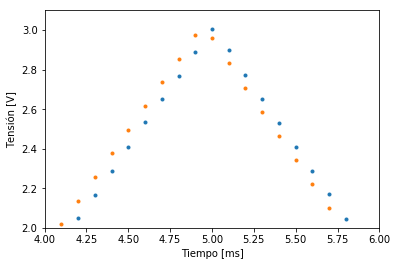

In [34]:
print(len(data))
plt.plot(np.multiply(tiempos,1000),data[0],'.')  
plt.plot(np.multiply(tiempos,1000),data[3],'.')
plt.xlim(0.004*1000,.006*1000)  
plt.ylim(2,3.1)  
plt.xlabel('Tiempo [ms]')
plt.ylabel('Tensión [V]')

In [21]:
data[0][10]

0.7589953791297539

In [22]:
data[3][10]

0.7619769596240422

In [32]:
np.savetxt('C:/Users/usuario/Documents/GitHub/Instrumentacion_y_control/Informe_2/Datos/Retardo_dos_canales_sampleo_senal_3V_1kHz.txt',(tiempos,data[0],data[3]))

Ahora vamos a hacer un barrido para ver si el salto se mantiene o fluctúa en el tiempo. Para esta medición usamos una señal triangular de 3 V pico, con una frecuencia de 5 Hz.

In [61]:
measure_time = 0.1
freq = 45000
nsamples = 4500
num_trials = 10000
saltos_tension = []

while len(saltos_tension)<num_trials:
    with nidaqmx.Task() as task:
        task.ai_channels.add_ai_voltage_chan('Dev1/ai3',
                                             terminal_config=nidaqmx.constants.TerminalConfiguration.DIFFERENTIAL)
        task.timing.cfg_samp_clk_timing(freq,samps_per_chan=nsamples)
        #print(task.timing.samp_quant_samp_mode)
        (tiempos,data) = adquisicion(task,measure_time,freq)
        (tiempos2,data2) = adquisicion(task,measure_time,freq)
    #    task.write([1.1, 2.2, 3.3, 4.4, 5.5], auto_start=True)
        if ((data[-1]-data[-2])*(data2[1]-data2[0]))>0:
            salto = data2[0]-data[-1]
            saltos_tension.append(np.abs(salto))
            if (len(saltos_tension)%100==0):
                print(len(saltos_tension))
        #print(task.timing.samp_clk_rate)

#plt.plot(tiempos,data)  
#plt.xlim(0,.1)    

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200


KeyboardInterrupt: 

4210

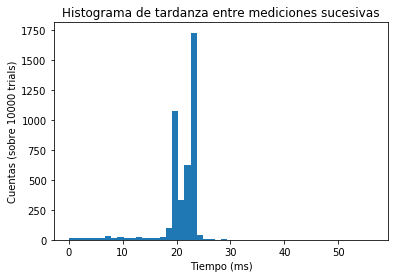

In [63]:
vector_tensiones = np.asarray(saltos_tension)
vector_tiempos = np.divide(0.1,6)*vector_tensiones
vector_tiempos = vector_tiempos*1000 # Lo pasamos a milisegundos
n, bins, patches = plt.hist(vector_tiempos,50)
plt.xlabel('Tiempo (ms)')
plt.ylabel('Cuentas (sobre 10000 trials)')
plt.title('Histograma de tardanza entre mediciones sucesivas')
len(vector_tensiones)

(0.08, 0.13)

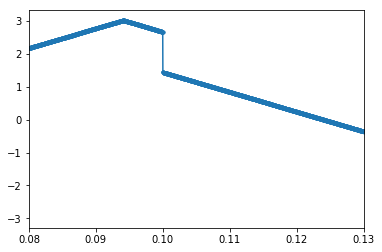

In [51]:
tiempos2_corrido = tiempos2 + tiempos[-1] + (tiempos[1] - tiempos[0])
tiempos_largo = np.concatenate((tiempos,tiempos2_corrido))
datos = np.concatenate((data,data2))
plt.plot(tiempos_largo,datos,'.-')
plt.xlim(0.08,0.13)

In [64]:
np.savetxt('C:/Users/usuario/Documents/GitHub/Instrumentacion_y_control/Informe_2/Datos/Tiempo_muerto_1canal_4210muestras_3V_5Hz.txt',vector_tensiones)